In [1]:
import math, keras
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D

# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.applications.mobilenet import MobileNet
# from tensorflow.keras.applications.resnet_rs import ResNetRS420
# from tensorflow.keras.applications.resnet_v2 import ResNet50V2
# from tensorflow.keras.applications.vgg19 import VGG19
# from tensorflow.keras.applications.nasnet import NASNetLarge
# from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
# from tensorflow.keras.applications.xception import Xception
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications.densenet import DenseNet169
# from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.applications.convnext import ConvNeXtXLarge

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# Каталог с данными для обучения
train_dir = 'DATASET-cats-vs-dogs/train'
# Каталог с данными для проверки
val_dir = 'DATASET-cats-vs-dogs/validation'
# Каталог с данными для тестирования
test_dir = 'DATASET-cats-vs-dogs/test'
# Размеры изображения
img_width, img_height = 224, 224
# Размер мини-выборки
batch_size = 64
# число классов
num_classes = 2

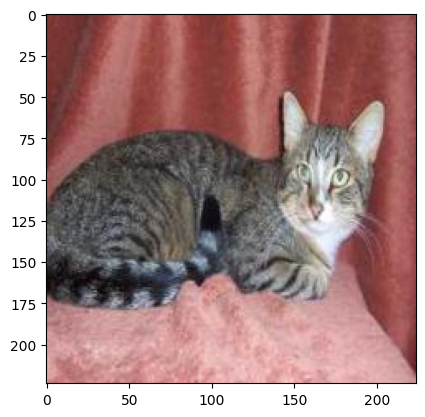

In [3]:
image_file_name = test_dir + '/cat/9.jpeg' # with watermark
img = Image.open(image_file_name)
plt.imshow(img)

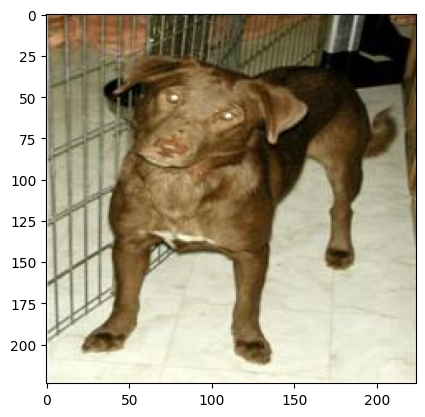

In [4]:
image_file_name = train_dir + '/dog/1.jpeg' # with watermark
img = Image.open(image_file_name)
plt.imshow(img)

In [5]:
train_datagen = ImageDataGenerator()#(rescale=1. / 255)#, featurewise_center=True, featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 20000 images belonging to 2 classes.


In [6]:
test_datagen = ImageDataGenerator()#(rescale=1. / 255)#, featurewise_center=True, featurewise_std_normalization=True)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 2500 images belonging to 2 classes.


In [7]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 2498 images belonging to 2 classes.


In [3]:
def model_maker(activation):
    # base_model = ResNet50(include_top=False, input_shape = (img_width, img_height, 3))
    # base_model = MobileNet(include_top=False, input_shape = (img_width, img_height, 3))
    # base_model = ResNetRS420(include_top=False, input_shape = (img_width, img_height, 3))
    # base_model = ResNet50V2(include_top=False, input_shape = (img_width, img_height, 3))
    # base_model = VGG19(include_top=False, input_shape = (img_width, img_height, 3))
    # base_model = NASNetLarge(include_top=False, input_shape = (img_width, img_height, 3))
    # base_model = InceptionResNetV2(include_top=False, input_shape = (img_width, img_height, 3))
    # base_model = Xception(include_top=False, input_shape = (img_width, img_height, 3))
    # base_model = InceptionV3(include_top=False, input_shape = (img_width, img_height, 3))
    # base_model = DenseNet169(include_top=False, input_shape = (img_width, img_height, 3))
    # base_model = EfficientNetV2S(include_top=False, input_shape = (img_width, img_height, 3))
    base_model = ConvNeXtXLarge(include_top=False, input_shape = (img_width, img_height, 3))
    
    for layer in base_model.layers[:]:
        layer.trainable = False # Freeze the layers
        
    input = Input(shape=(img_width, img_height, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model) # GlobalMaxPooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(num_classes, activation=activation)(custom_model) # activation = 'sigmoid', activation = 'softmax'
    return Model(inputs=input, outputs=predictions)

In [4]:
model = model_maker('softmax') #sigmoid

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 convnext_xlarge (Functiona  (None, 7, 7, 2048)        348147968 
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130  

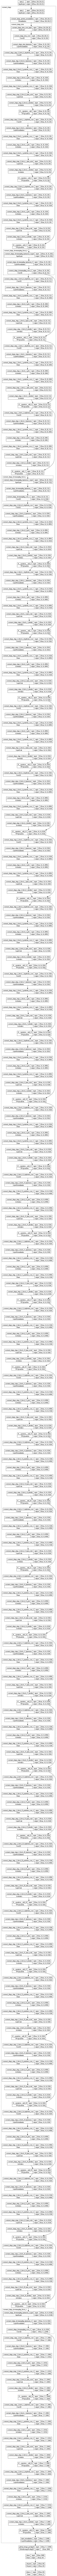

In [10]:
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True, to_file='myConvNeXtXLarge.png')

In [11]:
from keras import metrics

#Binary cross entropy of each label. So no really a binary classification problem but
#Calculating binary cross entropy for each label. 
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=[metrics.mae, metrics.categorical_accuracy])
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy', # 'categorical_crossentropy',
              metrics=['accuracy', 
                       metrics.AUC(num_thresholds=5),
                       metrics.BinaryAccuracy(threshold=0.5), # for balance a class-imbalanced data set
                       metrics.Precision(),
                       metrics.Recall(),
                       metrics.TruePositives(),
                       metrics.TrueNegatives(),
                       metrics.FalsePositives(),
                       metrics.FalseNegatives()])

In [12]:
# Обучаем модель с использованием генераторов
# train_generator - генератор данных для обучения
# validation_data - генератор данных для проверки

callback = tf.keras.callbacks.EarlyStopping(monitor='auc', patience=1)#(monitor='loss', patience=2)

# Need to run with real data to infer shape of different layers
history = model.fit(train_generator,
    steps_per_epoch=6,
    epochs=10,
    validation_data=val_generator,
    validation_steps=1,
    callbacks=[callback])

Epoch 1/10


6/6 [==============================] - 853s 144s/step - loss: 0.4608 - accuracy: 0.8255 - auc: 0.8711 - binary_accuracy: 0.8255 - precision: 0.8255 - recall: 0.8255 - true_positives: 317.0000 - true_negatives: 317.0000 - false_positives: 67.0000 - false_negatives: 67.0000 - val_loss: 0.1296 - val_accuracy: 0.9844 - val_auc: 0.9998 - val_binary_accuracy: 0.9844 - val_precision: 0.9844 - val_recall: 0.9844 - val_true_positives: 63.0000 - val_true_negatives: 63.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000
Epoch 2/10
6/6 [==============================] - 832s 142s/step - loss: 0.1165 - accuracy: 0.9922 - auc: 0.9972 - binary_accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - true_positives: 381.0000 - true_negatives: 381.0000 - false_positives: 3.0000 - false_negatives: 3.0000 - val_loss: 0.0256 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_true_positives: 64.0000 - val_true_n

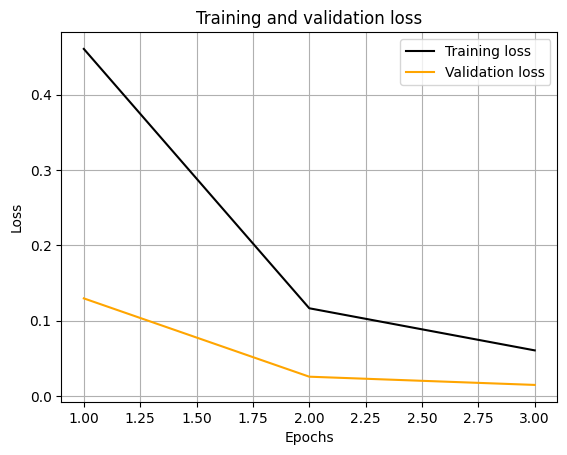

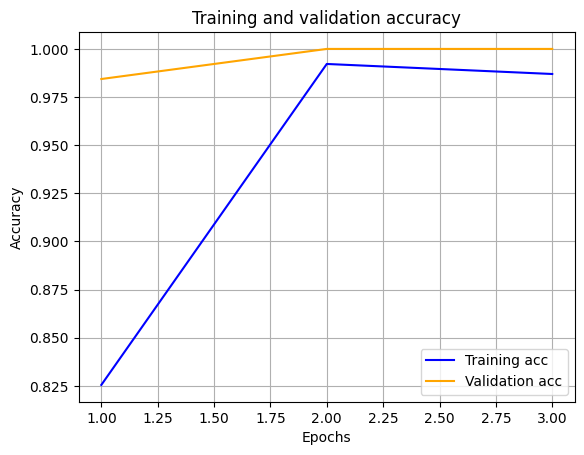

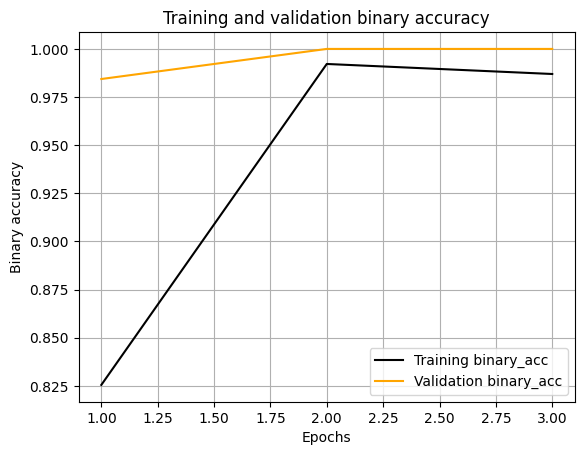

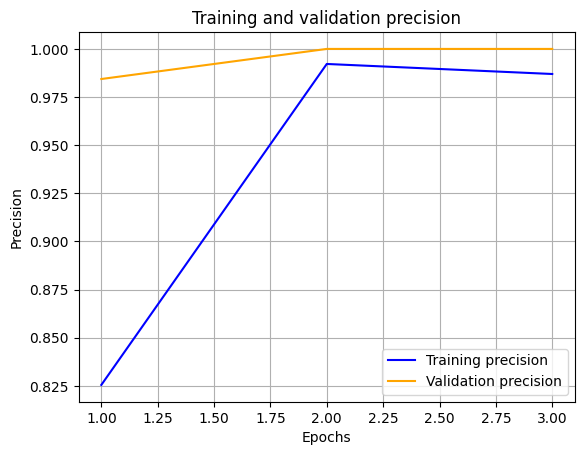

In [13]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'black', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
# plt.savefig('loss-5epochs.png')
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'orange', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
# plt.savefig('acc-5epochs.png')
plt.show()


binary_acc = history.history['binary_accuracy']
val_binary_acc = history.history['val_binary_accuracy']
plt.plot(epochs, binary_acc, 'black', label='Training binary_acc')
plt.plot(epochs, val_binary_acc, 'orange', label='Validation binary_acc')
plt.title('Training and validation binary accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary accuracy')
plt.legend()
plt.grid()
# plt.savefig('binary_acc-5epochs.png')
plt.show()


precision = history.history['precision']
val_precision = history.history['val_precision']
plt.plot(epochs, precision, 'blue', label='Training precision')
plt.plot(epochs, val_precision, 'orange', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid()
# plt.savefig('precision-5epochs.png')
plt.show()

In [14]:
scores = model.evaluate(test_generator)
# print(f"\nТочность на тестовых данных: {(scores[1]*100):.2f}%")

40/40 [==============================] - 4658s 116s/step - loss: 0.0190 - accuracy: 0.9964 - auc: 0.9976 - binary_accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - true_positives: 2489.0000 - true_negatives: 2489.0000 - false_positives: 9.0000 - false_negatives: 9.0000


In [15]:
print(model.metrics_names)
print(scores)

['loss', 'accuracy', 'auc', 'binary_accuracy', 'precision', 'recall', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives']
[0.01901322416961193, 0.9963971376419067, 0.9975894093513489, 0.9963971376419067, 0.9963971376419067, 0.9963971376419067, 2489.0, 2489.0, 9.0, 9.0]


In [16]:
from math import sqrt
mcc = (scores[-4]*scores[-3] - scores[-2]*scores[-1])/sqrt((scores[-4]+scores[-2])*(scores[-4]+scores[-1])*(scores[-3]+scores[-2])*(scores[-3]+scores[-1]))
print(f'Коэффициент корреляции Мэтьюса = {mcc}')

Коэффициент корреляции Мэтьюса = 0.9927942353883107


In [9]:
# import numpy as np
# import seaborn as sns
# # Confusion matrix 
# y_pred = np.argmax(model.predict(test_generator), axis=1) 
# # y_true = np.concatenate([y for x, y in test_generator], axis=0)
# true_classes = test_generator.classes
# class_labels = list(test_generator.class_indices.keys())
# cm = tf.math.confusion_matrix(true_classes, y_pred)

# # Plotting the confusion matrix 
# plt.figure(figsize=(5, 5)) 
# sns.heatmap(cm, annot=True, fmt='g') 
# plt.xlabel('Predicted') 
# plt.ylabel('Actual') 
# plt.show()

In [10]:
# from sklearn.metrics import classification_report

# # report = classification_report(y_true, y_pred) 
# report = classification_report(true_classes, y_pred, target_names=class_labels)
# print(report) 

In [ ]:
model.save('pretrained-classificator.keras')

In [5]:
from keras import metrics

# model = keras.models.load_model("pretrained-classificator.keras")
model.load_weights("pretrained-classificator.keras")
print("Loaded model from disk")

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy', # 'categorical_crossentropy',
              metrics=['accuracy', 
                       metrics.AUC(num_thresholds=5),
                       metrics.BinaryAccuracy(threshold=0.5), # for balance a class-imbalanced data set
                       metrics.Precision(),
                       metrics.Recall(),
                       metrics.TruePositives(),
                       metrics.TrueNegatives(),
                       metrics.FalsePositives(),
                       metrics.FalseNegatives()])

test_dir = 'DATASET-cats-vs-dogs/test'
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical')

Loaded model from disk
Found 2498 images belonging to 2 classes.


In [8]:
predicts = model.predict(test_generator)

40/40 [==============================] - 4612s 115s/step


In [11]:
print(type(predicts))

<class 'numpy.ndarray'>


In [15]:
print(predicts.shape)

(2498, 2)


In [24]:
# predicts = predicts.tolist()
# print(predicts)
for i in predicts:
    if i[0] < i[1]:
        print("0", i[1])
    else:
        print("", i[0])

0.9999992847442627
0.9999996423721313
0.9999947547912598
0.9999971389770508
0.9999897480010986
0.9999836683273315
0.9999990463256836
0.9999911785125732
0.8708789348602295
0.9999977350234985
0.9999527931213379
0.9999997615814209
0.9974716901779175
0.9999973773956299
0.9999995231628418
1.0
0.9999994039535522
0.9999994039535522
0.9999974966049194
0.9999982118606567
0.9999908208847046
0.9996447563171387
0.999996542930603
0.9999947547912598
0.9999362230300903
0.9999997615814209
0.9999988079071045
0.9999995231628418
1.0
0.9999988079071045
1.0
0.9999246597290039
1.0
0.9999990463256836
1.0
0.9999998807907104
0.9999276399612427
0.9999309778213501
0.9999997615814209
0.9999880790710449
0.9598861336708069
0.9998875856399536
0.9999995231628418
0.9999836683273315
0.9991790652275085
0.9999997615814209
0.9999886751174927
1.0
0.999976396560669
0.9999979734420776
0.9999819993972778
0.9999997615814209
0.9999992847442627
0.9999970197677612
1.0
0.9998522996902466
0.9999862909317017
0.9999978542327881
0.999

1/1 [==============================] - 5s 5s/step
Cat 0.9999964


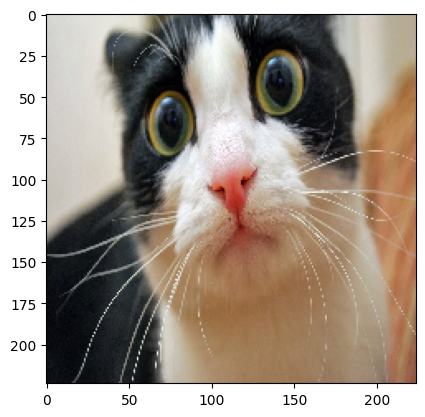

In [11]:
import numpy as np
from keras.preprocessing import image 

#Input image 
def predictclass(image_path):
    test_image = image.load_img(image_path, target_size=(224,224)) 
    
    #For show image 
    plt.imshow(test_image) 
    test_image = image.img_to_array(test_image) 
    test_image = np.expand_dims(test_image,axis=0) 
    
    # Result array 
    result = model.predict(test_image) 
    
    #Mapping result array with the main name list 
    for i in result:
        if i[0] > i[1]:
            print("Cat", i[0])
        else:
            print("Dog", i[1])

predictclass('cat.17.jpg')

1/1 [==============================] - 5s 5s/step
Cat 0.99999917


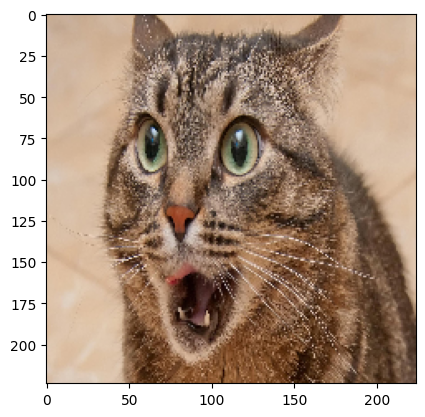

In [12]:
predictclass('dog.18.jpg')

1/1 [==============================] - 5s 5s/step
Dog 0.9699211


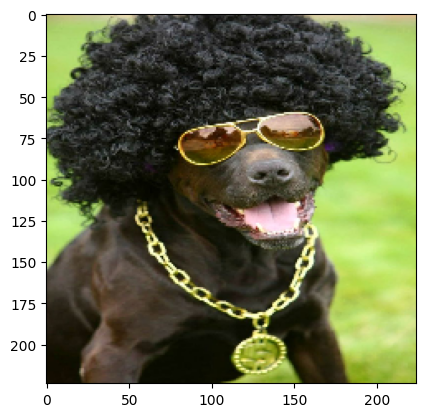

In [14]:
predictclass('dog.21.jpg')